## Importações

In [1]:
import math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque, defaultdict
from dataclasses import dataclass
from typing import List, Dict, Optional, Callable

plt.rcParams["figure.figsize"] = (8, 5)


## Configuração Rápida

In [2]:
N_PAGES = 50
LENGTH  = 5000
FRAMES  = list(range(2, 26, 2))
N_TRIALS = 10
ALPHA = 0.7

random.seed(7); np.random.seed(7)

## Ideia do Splay‑Adaptive

In [3]:
# score = alpha * timestamp + (1 - alpha) * frequency
# Evict: menor score

## Ótimo (eficiente)

In [4]:
def simulate_optimal(refs: List[int], frames: int) -> int:
    positions: Dict[int, deque] = defaultdict(deque)
    for idx, page in enumerate(refs):
        positions[page].append(idx)
    faults = 0
    memory: List[int] = []
    for i, p in enumerate(refs):
        positions[p].popleft()
        if p in memory:
            continue
        faults += 1
        if len(memory) < frames:
            memory.append(p)
        else:
            def next_idx(page):
                return positions[page][0] if positions[page] else math.inf
            victim = max(memory, key=lambda q: next_idx(q))
            memory[memory.index(victim)] = p
    return faults


## LRU

In [5]:
def simulate_lru(refs: List[int], frames: int) -> int:
    faults = 0
    order = deque(); in_mem: Dict[int, None] = {}
    for p in refs:
        if p in in_mem:
            order.remove(p); order.append(p)
        else:
            faults += 1
            if len(order) < frames:
                order.append(p); in_mem[p] = None
            else:
                victim = order.popleft(); del in_mem[victim]
                order.append(p); in_mem[p] = None
    return faults


## Árvore Splay + Splay‑Adaptive

In [6]:
@dataclass
class SplayNode:
    key: float
    page: int
    left: Optional['SplayNode']=None
    right: Optional['SplayNode']=None
    parent: Optional['SplayNode']=None

class SplayTree:
    def __init__(self):
        self.root: Optional[SplayNode] = None
    def _rotate_left(self, x: SplayNode):
        y = x.right
        if not y: return
        x.right = y.left
        if y.left: y.left.parent = x
        y.parent = x.parent
        if not x.parent: self.root = y
        elif x == x.parent.left: x.parent.left = y
        else: x.parent.right = y
        y.left = x; x.parent = y
    def _rotate_right(self, x: SplayNode):
        y = x.left
        if not y: return
        x.left = y.right
        if y.right: y.right.parent = x
        y.parent = x.parent
        if not x.parent: self.root = y
        elif x == x.parent.left: x.parent.left = y
        else: x.parent.right = y
        y.right = x; x.parent = y
    def _splay(self, x: SplayNode):
        while x.parent:
            if not x.parent.parent:
                if x.parent.left == x: self._rotate_right(x.parent)
                else: self._rotate_left(x.parent)
            elif x.parent.left == x and x.parent.parent.left == x.parent:
                self._rotate_right(x.parent.parent); self._rotate_right(x.parent)
            elif x.parent.right == x and x.parent.parent.right == x.parent:
                self._rotate_left(x.parent.parent); self._rotate_left(x.parent)
            elif x.parent.left == x and x.parent.parent.right == x.parent:
                self._rotate_right(x.parent); self._rotate_left(x.parent)
            else:
                self._rotate_left(x.parent); self._rotate_right(x.parent)
    def _bst_insert(self, node: SplayNode):
        y = None; x = self.root
        while x:
            y = x
            if node.key < x.key: x = x.left
            else: x = x.right
        node.parent = y
        if not y: self.root = node
        elif node.key < y.key: y.left = node
        else: y.right = node
        self._splay(node)
    def insert(self, key: float, page: int) -> SplayNode:
        node = SplayNode(key, page); self._bst_insert(node); return node
    def _transplant(self, u: SplayNode, v: Optional[SplayNode]):
        if not u.parent: self.root = v
        elif u == u.parent.left: u.parent.left = v
        else: u.parent.right = v
        if v: v.parent = u.parent
    def _subtree_min(self, x: SplayNode) -> SplayNode:
        while x.left: x = x.left
        return x
    def delete(self, node: SplayNode):
        self._splay(node)
        if not node.left: self._transplant(node, node.right)
        elif not node.right: self._transplant(node, node.left)
        else:
            y = self._subtree_min(node.right)
            if y.parent != node:
                self._transplant(y, y.right)
                y.right = node.right
                if y.right: y.right.parent = y
            self._transplant(node, y)
            y.left = node.left
            if y.left: y.left.parent = y
        node.left = node.right = node.parent = None
    def pop_min(self):
        if not self.root: return None
        m = self._subtree_min(self.root)
        key, page = m.key, m.page
        self.delete(m)
        return key, page

def simulate_splay_adaptive(refs: List[int], frames: int, alpha: float = 0.7) -> int:
    faults = 0
    tree = SplayTree(); page_to_node: Dict[int, SplayNode] = {}
    page_freq: Dict[int, int] = {}; ts = 0
    for p in refs:
        ts += 1
        page_freq[p] = page_freq.get(p, 0) + 1
        score = alpha * ts + (1 - alpha) * page_freq[p]
        if p in page_to_node:
            tree.delete(page_to_node[p])
        else:
            faults += 1
            if len(page_to_node) >= frames:
                _, victim = tree.pop_min()
                if victim in page_to_node: del page_to_node[victim]
        page_to_node[p] = tree.insert(score, p)
    return faults


## Geradores de Traços

In [7]:
def gen_80_20(n_pages: int, length: int) -> List[int]:
    hot_n = max(1, int(n_pages * 0.2)); hot = list(range(hot_n))
    return [random.choice(hot) if random.random() < 0.8 else random.randrange(n_pages) for _ in range(length)]

def gen_working_set(n_pages: int, length: int, window: int = 30, set_size: int = 8) -> List[int]:
    refs = []; i = 0
    while i < length:
        start = random.randrange(0, max(1, n_pages - set_size + 1))
        active = list(range(start, min(n_pages, start + set_size))) or list(range(n_pages))
        chunk = min(window, length - i)
        for _ in range(chunk):
            refs.append(random.choice(active))
        i += chunk
    return refs

def gen_strong_locality(n_pages: int, length: int, hot_size: int = 6, p_hot: float = 0.98) -> List[int]:
    hot = list(range(min(hot_size, n_pages)))
    return [random.choice(hot) if (random.random() < p_hot and hot) else random.randrange(n_pages) for _ in range(length)]

## Runner de Experimentos

In [8]:
def run_batch(generator: Callable[..., List[int]], gen_kwargs: dict, frames_list: List[int], n_trials: int, alpha: float):
    rows = []
    for f in frames_list:
        opt = lru = splay = 0
        for _ in range(n_trials):
            refs = generator(**gen_kwargs)
            opt   += simulate_optimal(refs, f)
            lru   += simulate_lru(refs, f)
            splay += simulate_splay_adaptive(refs, f, alpha)
        rows.append({"Frames": f, "Ótimo (média)": opt/n_trials, "LRU (média)": lru/n_trials, "Splay-Adaptive (média)": splay/n_trials})
    return pd.DataFrame(rows).set_index("Frames")


## Rodando Cenários & Gráficos

,Ótimo (média),LRU (média),Splay-Adaptive (média)
Frames,,,
2,3560.1,4291.4,4218.5
4,2408.4,3617.4,3404.8
6,1708.7,2945.8,2595.5
8,1220.8,2336.8,1807.2
10,907.7,1838.9,1152.6
12,692.6,1379.5,842.6
14,580.7,1046.9,770.0
16,481.6,804.8,685.8
18,427.7,695.4,651.1


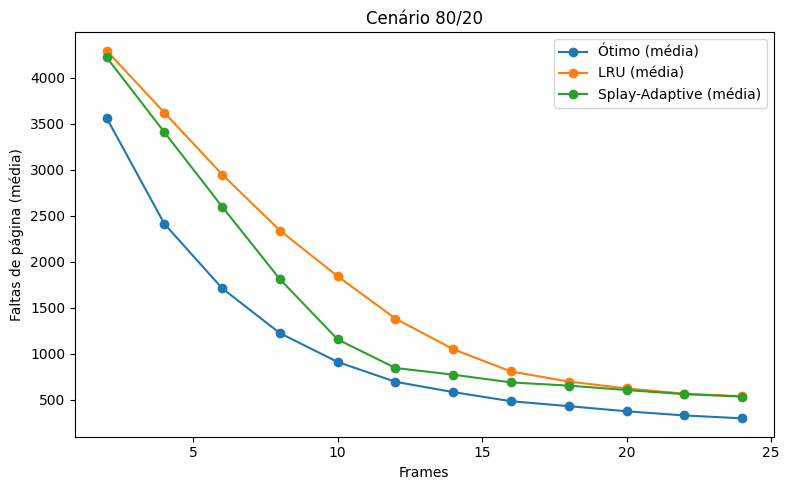

,Ótimo (média),LRU (média),Splay-Adaptive (média)
Frames,,,
2,3055.7,3798.5,3868.7
4,1845.6,2721.9,2909.8
6,1283.8,1755.8,2020.0
8,1018.5,1139.1,1407.1
10,876.9,1073.0,1190.0
12,785.8,1057.9,1112.2
14,670.4,976.8,986.4
16,597.3,909.0,908.8
18,532.0,854.3,850.7


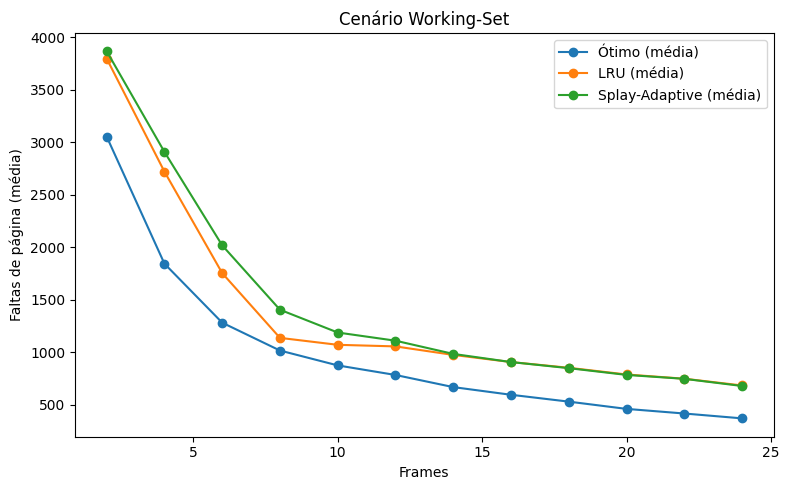

,Ótimo (média),LRU (média),Splay-Adaptive (média)
Frames,,,
2,2575.2,3406.0,3391.8
4,981.1,1820.2,1759.9
6,157.0,278.6,170.3
8,85.6,97.2,94.3
10,72.4,88.9,88.9
12,60.2,77.4,77.4
14,58.3,76.4,76.4
16,55.6,75.5,75.5
18,51.1,70.5,70.5


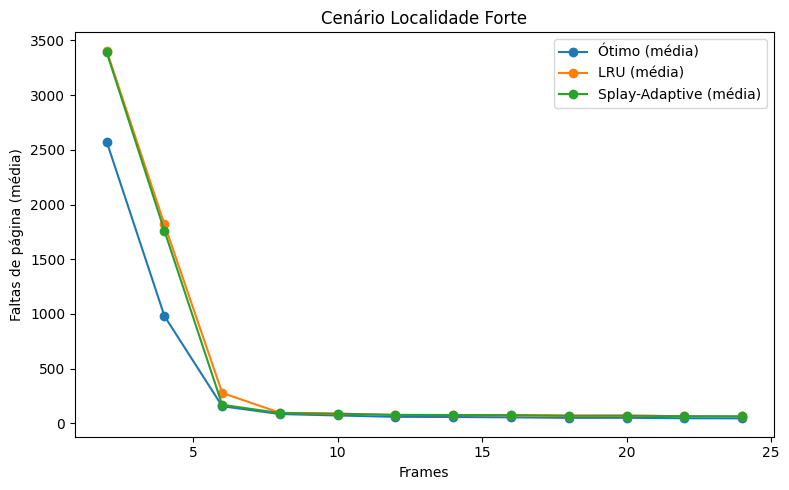

In [9]:
df_8020 = run_batch(gen_80_20, {"n_pages": N_PAGES, "length": LENGTH}, FRAMES, N_TRIALS, ALPHA)
df_ws   = run_batch(gen_working_set, {"n_pages": N_PAGES, "length": LENGTH, "window":30, "set_size":8}, FRAMES, N_TRIALS, ALPHA)
df_loc  = run_batch(gen_strong_locality, {"n_pages": N_PAGES, "length": LENGTH, "hot_size":6, "p_hot":0.98}, FRAMES, N_TRIALS, ALPHA)

def plot_df(df: pd.DataFrame, title: str):
    plt.figure()
    for col in df.columns:
        plt.plot(df.index, df[col], marker="o", label=col)
    plt.xlabel("Frames"); plt.ylabel("Faltas de página (média)"); plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

display(df_8020.round(2)); plot_df(df_8020, "Cenário 80/20")
display(df_ws .round(2)); plot_df(df_ws , "Cenário Working-Set")
display(df_loc.round(2)); plot_df(df_loc, "Cenário Localidade Forte")

## Observações Finais

- **Ótimo** é o limite teórico inferior (usa conhecimento do futuro).
- **LRU** funciona muito bem quando há **localidade temporal**.
- **Splay‑Adaptive** equilibra recência e frequência; tende a **superar o LRU** em cargas 80/20 e working‑set cíclico.
- Ajuste **ALPHA** para explorar diferentes regimes (0.5, 0.7, 0.9).